# Sensitivity Analysis 

The purpose of this analysis is to determine the optimal number of topics for the NYT dataset. By evaluating the coherence scores across different numbers of topics, we aim to identify the configuration that produces the most coherent and meaningful topics. This process helps in uncovering the underlying structure and themes within the dataset.

In [1]:
import pickle
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
bow_matrix = sparse.load_npz("bow_matrix.npz")

In [3]:
with open('out/count_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

In [4]:
with open('out/lda_model.pkl', 'rb') as g:
    lda_model = pickle.load(g)

In [5]:
# This is the vocabulary
feature_names = vectorizer.get_feature_names_out()

def get_topic_words(lda_model=lda_model, num_top_words=50):
    num_top_words = 50

    topic_words = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words_idx = topic.argsort()[:-num_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topic_words.append(top_words)

    return topic_words

In [6]:
texts = vectorizer.get_feature_names_out()

df = pd.read_csv("processced text.csv")

dictionary = Dictionary(df['preprocessed_text'].apply(lambda x: list(x)))

In [7]:
from gensim.models.coherencemodel import CoherenceModel

def calc_coherence(topic_idx, words):
    coherence_model_lda = CoherenceModel(
        topics=words, texts=df['preprocessed_text'], dictionary=dictionary, coherence='c_v'
    )
    return topic_idx, coherence_model_lda.get_coherence()

In [8]:
from sklearn.decomposition import LatentDirichletAllocation

def train_lda(num_topics):
    lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=10, random_state=42)
    lda_model.fit(bow_matrix)
    topic_words = get_topic_words(lda_model)

    total_score = 0
    for topic in topic_words:
        _, score=  calc_coherence(num_topics, topic)
        total_score += score

    avg_coherence_score = total_score / num_topics

    return num_topics, {'model': lda_model, 'avg_coherence_score': avg_coherence_score }

In [9]:
model_score_map = {}

for num_topics in range(2, 9):
    _x, m_score = train_lda(num_topics)

    model_score_map[_x] = m_score

In [10]:
model_score_map

{2: {'model': LatentDirichletAllocation(n_components=2, random_state=42),
  'avg_coherence_score': 0.47187079950175437},
 3: {'model': LatentDirichletAllocation(n_components=3, random_state=42),
  'avg_coherence_score': 0.4689642578460176},
 4: {'model': LatentDirichletAllocation(n_components=4, random_state=42),
  'avg_coherence_score': 0.4705796516349852},
 5: {'model': LatentDirichletAllocation(n_components=5, random_state=42),
  'avg_coherence_score': 0.4702850841045194},
 6: {'model': LatentDirichletAllocation(n_components=6, random_state=42),
  'avg_coherence_score': 0.46368361222170856},
 7: {'model': LatentDirichletAllocation(n_components=7, random_state=42),
  'avg_coherence_score': 0.46758934536312574},
 8: {'model': LatentDirichletAllocation(n_components=8, random_state=42),
  'avg_coherence_score': 0.4642165246938492}}

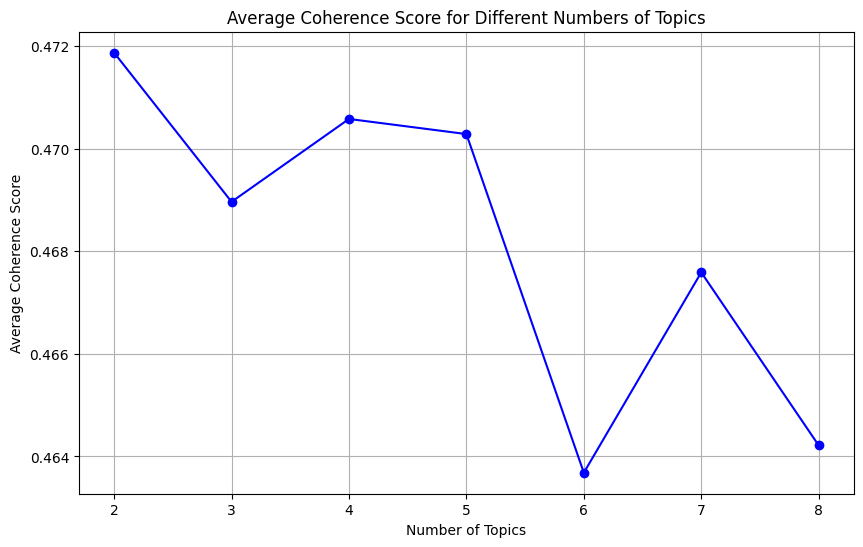

In [11]:
# Extracting x and y values
x = list(model_score_map.keys())
y = [entry['avg_coherence_score'] for entry in model_score_map.values()]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', color='b', linestyle='-')
plt.xlabel('Number of Topics')
plt.ylabel('Average Coherence Score')
plt.title('Average Coherence Score for Different Numbers of Topics')
plt.xticks(x)
plt.grid(True)
plt.show()

# Observations

## Average Coherence Score Trend
* As the number of topics increases from 2 to 8, there is a slight fluctuation in the average coherence score.
* The average coherence score ranges from approximately `0.464` to `0.472`, indicating a relatively consistent performance across different numbers of topics.
## Optimal Number of Topics
* The highest average coherence score is achieved with 2 topics, with a score of approximately `0.472`.
* As the number of topics increases beyond 2, there is a slight decrease in the average coherence score, with scores ranging between `0.463` and `0.468` for 6 to 7 topics.
## Interpretability vs. Granularity:
* A lower number of topics (e.g., 2) may result in higher coherence scores, indicating more interpretable and distinct topics.
* However, increasing the number of topics beyond a certain threshold (e.g., 6 or 7) may lead to a decrease in coherence scores, suggesting that the topics become more granular and potentially less interpretable.
## Robustness
* The LDA model demonstrates robustness to changes in the number of topics, as the average coherence scores remain relatively close to each other across different configurations.
* This suggests that the model is not overly sensitive to small variations in the number of topics within the specified range.
## Considerations
* The choice of the number of topics should consider a balance between coherence and granularity. A higher coherence score does not necessarily imply better topic quality if the topics become too broad or overlapping.
* It's essential to evaluate the coherence scores in conjunction with qualitative assessments of the topics to ensure they are meaningful and interpretable.


## So is `n_components=2` optimal?

Using an LDA model with only 2 topics for classifying articles may not be the most effective approach for several reasons:

1. With only 2 topics, the LDA model may struggle to capture the diverse range of topics present in NYT articles effectively. This lack of granularity can result in topics that are too broad or overlapping, making it challenging to accurately classify articles into meaningful categories resulting in the lack of topic differentation.

2. Limiting the number of topics to 2 can lead to a significant loss of information. NYT covers a wide range of topics spanning politics, business, sports, entertainment, science, and more. A binary classification of articles into just two broad topics would not capture this richness of content adequately. This results in loss of information

3. A binary classification model may lack the discriminative power needed to distinguish between closely related topics or subtopics within the same category. This can result in misclassification of articles and reduced performance in tasks such as recommendations.



# Topic Similarity

We want to quantify the degree of similarity or dissimilarity between topics identified by different LDA configurations. This allows for a direct comparison of topics generated by LDA models with different numbers of topics. By visualizing the similarity matrices, we can identify patterns and trends in how topics evolve as the number of topics varies.

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calc_lda_model_topic_similarity_matrix(idx):

    model = model_score_map[idx]['model']

    topic_words = get_topic_words(model)

    bow = vectorizer.transform([' '.join(words) for words in topic_words])

    similarity_matrix = []

    for topic_1 in bow:
        for topic_2 in bow:
            similarity_matrix.append(cosine_similarity(topic_1, topic_2)[0][0])

    similarity_matrix = np.matrix(similarity_matrix).reshape(len(topic_words), len(topic_words))

    return similarity_matrix

[(2, '0.5900'), (3, '0.4622'), (4, '0.4125'), (5, '0.3424'), (6, '0.2889'), (7, '0.2710'), (8, '0.2419')]


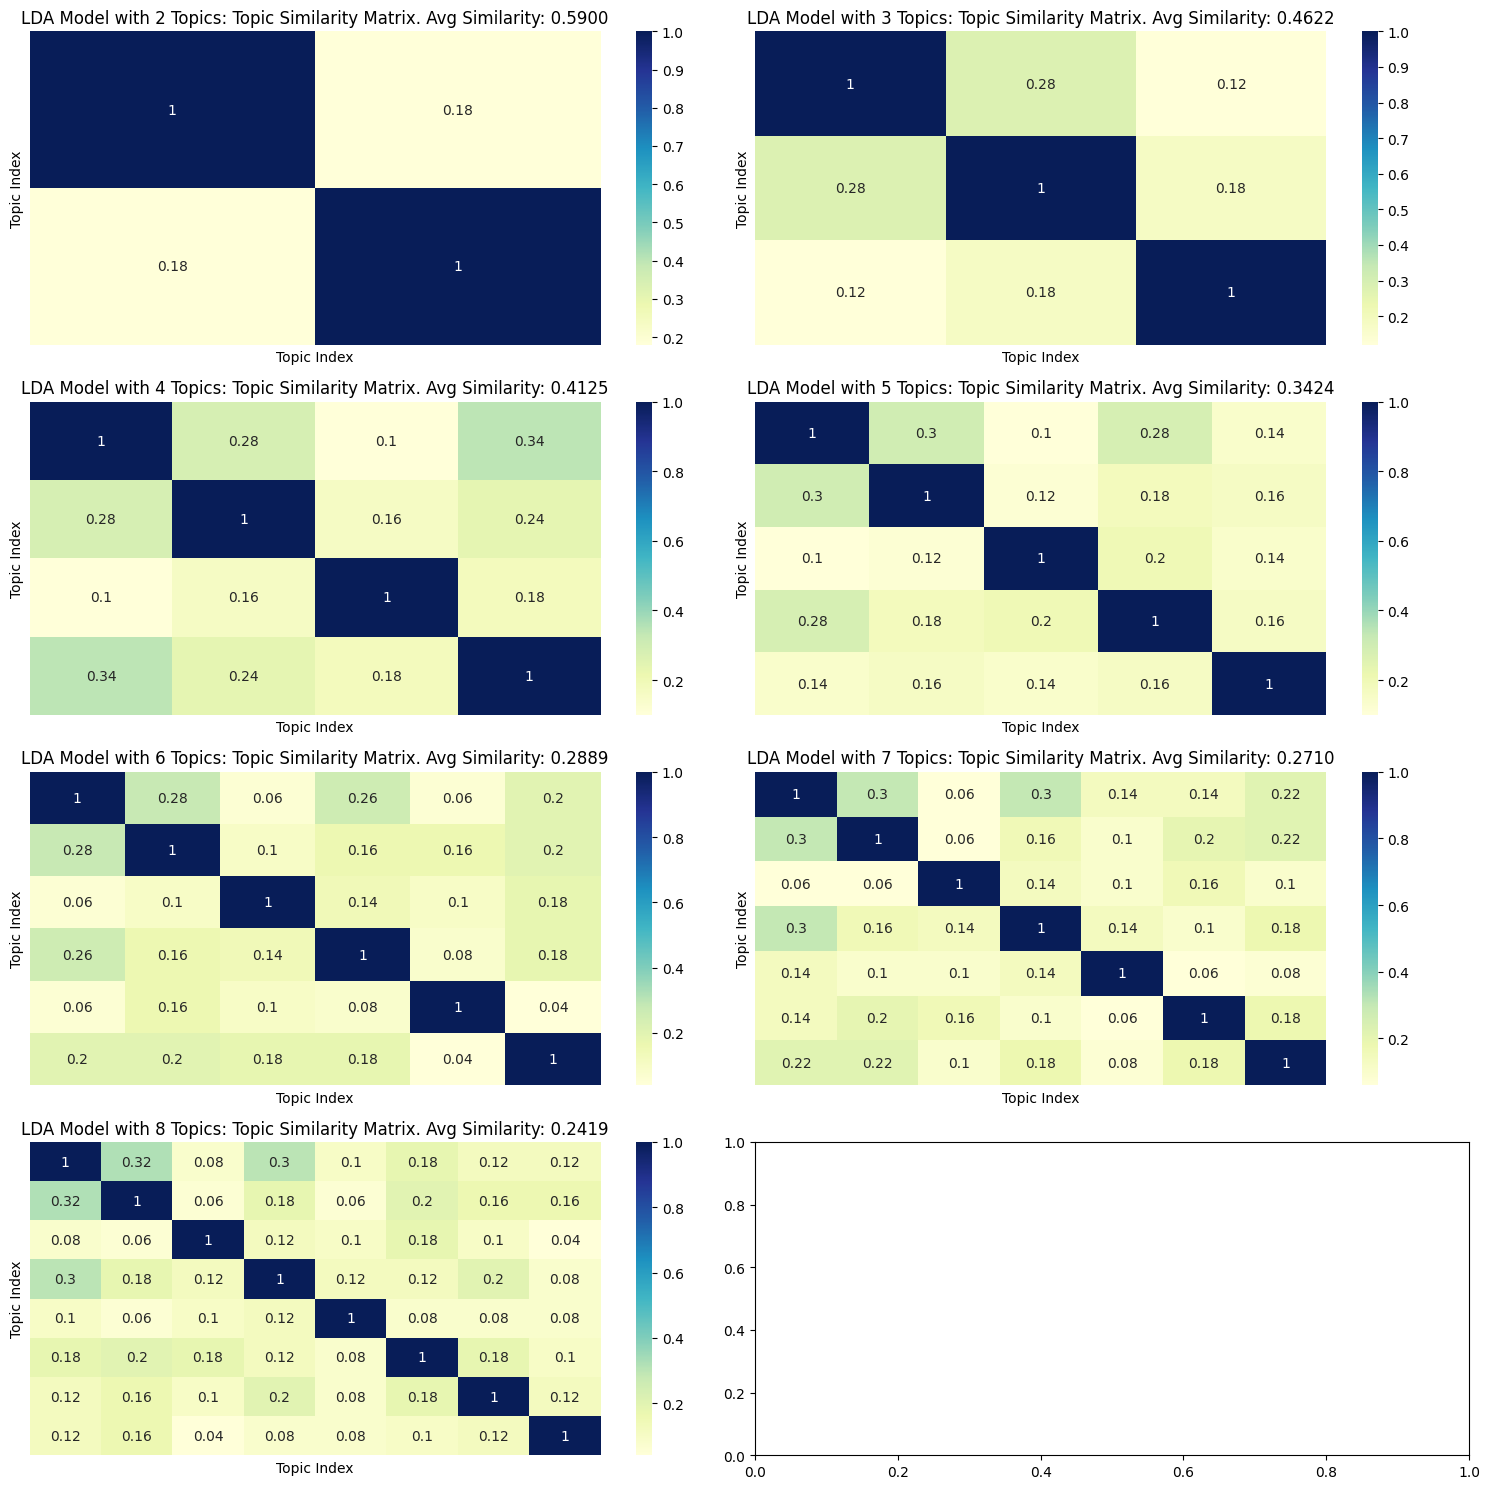

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the number of rows and columns for the subplot grid
num_rows = 4
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

sim_idx = []

# Iterate over each LDA model and display the similarity matrix heatmap
for x in range(2, 9):
    similarity_matrix = calc_lda_model_topic_similarity_matrix(x)
    avg_sim = '{0:.4f}'.format(np.average(similarity_matrix))


    sim_idx.append((x, avg_sim))

    row = (x - 2) // num_cols
    col = (x - 2) % num_cols
    ax = axes[row, col]
    sns.heatmap(similarity_matrix, annot=True, cmap="YlGnBu", xticklabels=False, yticklabels=False, ax=ax)
    ax.set_title(f"LDA Model with {x} Topics: Topic Similarity Matrix. Avg Similarity: {avg_sim}")
    ax.set_xlabel("Topic Index")
    ax.set_ylabel("Topic Index")


print(sim_idx)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Observations

The LDA models were constructed with varying numbers of topics ranging from 2 to 8.

* As the number of topics increases, the average similarity score decreases consistently. This suggests that as the LDA model becomes more granular with a higher number of topics, the topics become less similar to each other on average.

* Higher similarity scores indicate a greater degree of overlap or coherence between topics, suggesting that the topics are more closely related or represent similar themes. Conversely, lower similarity scores imply that the topics are more distinct or diverse from each other.

A higher similarity score may indicate a more cohesive set of topics, but it could also imply a lack of granularity. Conversely, a lower similarity score may suggest more distinct topics but could lead to potential overlaps or ambiguity in topic interpretation.

